In [3]:
#importing library classes
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
from scipy.linalg import eigh_tridiagonal

In [ ]:
# Technique 1

In [4]:
Nx = 301
Nt = 100000
dx = 1/(Nx-1)
dt=1e-7
x = np.linspace(0, 1, Nx)

In [5]:
Nx = 301
Nt = 100000
dx = 1/(Nx-1)
dt=1e-7
x = np.linspace(0, 1, Nx)
psi0 = np.sqrt(2)*np.sin(np.pi*x)
mu, sigma = 1/2, 1/20
V = -1e4*np.exp(-(x-mu)**2/(2*sigma**2))

In [6]:
dt/dx**2

0.008999999999999998

Text(0, 0.5, '$V(x)$')

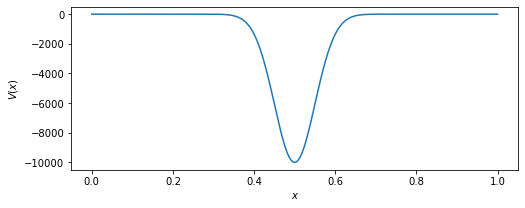

In [7]:
plt.figure(figsize=(8,3))
plt.plot(x,V)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')

In [8]:
psi = np.zeros([Nt,Nx])
psi[0] = psi0

In [9]:
psi

array([[0.00000000e+00, 1.48093391e-02, 2.96170542e-02, ...,
        2.96170542e-02, 1.48093391e-02, 1.73191211e-16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [10]:
@numba.jit("c16[:,:](c16[:,:])", nopython=True, nogil=True)
def compute_psi(psi):
    for t in range(0, Nt-1):
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t][i] + 1j/2 * dt/dx**2 * (psi[t][i+1] - 2*psi[t][i] + psi[t][i-1]) - 1j*dt*V[i]*psi[t][i]
        
        normal = np.sum(np.absolute(psi[t+1])**2)*dx
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t+1][i]/normal
        
    return psi

In [11]:
psi_m1 = compute_psi(psi.astype(complex))

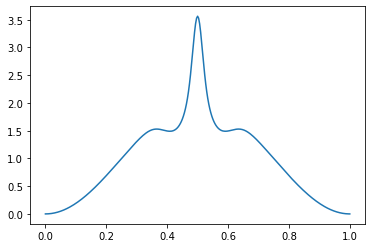

In [12]:
plt.plot(x, np.absolute(psi_m1[5000])**2)
#np.sum(np.absolute(psi_m1[10000])**2)*dx

In [13]:
#Techique 2

In [14]:
Nx = 301
dx = 1/(Nx-1)
x = np.linspace(0, 1, Nx)
psi0 = np.sqrt(2)*np.sin(np.pi*x)

def V(x):
    mu, sigma = 1/2, 1/20
    return -1e4*np.exp(-(x-1/2)**2/(2*(1/20)**2))

In [17]:
d = 1/dx**2 + V(x)[1:-1]
e = -1/(2*dx**2) * np.ones(len(d)-1)
w, v = eigh_tridiagonal(d, e)

In [18]:
E_js = w[0:70]
psi_js = np.pad(v.T[0:70], [(0, 0), (1, 1)], mode='constant')
cs = np.dot(psi_js, psi0)
def psi_m2(t):
    return psi_js.T@(cs*np.exp(-1j*E_js*t))

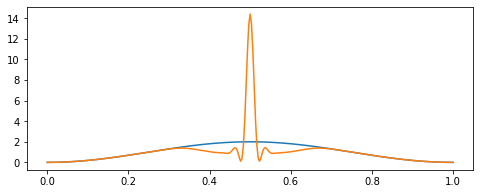

In [19]:
plt.figure(figsize=(8,3))
plt.plot(x, psi0**2)
plt.plot(x, np.absolute(psi_m2(10000*dt))**2)

In [21]:
# Animation

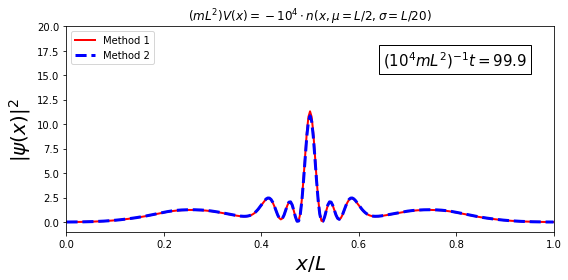

In [22]:
def animate(i):
    ln1.set_data(x, np.absolute(psi_m1[100*i])**2)
    ln2.set_data(x, np.absolute(psi_m2(100*i*dt))**2)
    time_text.set_text('$(10^4 mL^2)^{-1}t=$'+'{:.1f}'.format(100*i*dt*1e4))
    
fig, ax = plt.subplots(1,1, figsize=(8,4))
#ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Method 1')
ln2, = plt.plot([], [], 'b--', lw=3, markersize=8, label='Method 2')
time_text = ax.text(0.65, 16, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(-1, 20)
ax.set_xlim(0,1)
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x/L$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('$(mL^2)V(x) = -10^4 \cdot n(x, \mu=L/2, \sigma=L/20)$')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pen.gif',writer='pillow',fps=50,dpi=100)